In [2]:
import pandas as pd
import networkx as nx
import pickle
import os
import matplotlib.pyplot as plt
import seaborn as sns

# Set plotting style
sns.set_style("whitegrid")

# Define the path to our processed data
PROCESSED_DATA_PATH = "../data/processed/"

print("Loading the graph from the pickle file...")

# Load the graph object from the file
graph_path = os.path.join(PROCESSED_DATA_PATH, "movie_actor_graph.gpickle")
with open(graph_path, 'rb') as f:
    B = pickle.load(f)

print("Graph loaded successfully!")
print("--- Graph Information ---")
num_nodes = B.number_of_nodes()
num_edges = B.number_of_edges()
print(f"Number of nodes: {num_nodes}")
print(f"Number of edges: {num_edges}")
if num_nodes > 0:
    avg_degree = (2 * num_edges) / num_nodes
    print(f"Average degree: {avg_degree:.2f}")

Loading the graph from the pickle file...
Graph loaded successfully!
--- Graph Information ---
Number of nodes: 1843257
Number of edges: 3957929
Average degree: 4.29


In [3]:
# --- Step 2: Separate nodes by type ---

# We'll use a dictionary comprehension to efficiently get the 'type' attribute for all nodes
node_types = nx.get_node_attributes(B, 'type')

# Create separate lists of actor and movie node IDs
actor_nodes = [node for node, node_type in node_types.items() if node_type == 'actor']
movie_nodes = [node for node, node_type in node_types.items() if node_type == 'movie']

print(f"Identified {len(actor_nodes)} actor nodes.")
print(f"Identified {len(movie_nodes)} movie nodes.")

Identified 1314337 actor nodes.
Identified 528728 movie nodes.


In [5]:
# --- Step 3: Analyze Actor Degrees ---

print("Calculating degrees for all actor nodes...")
# B.degree() returns the degree for all nodes, but we can pass a list to get it for just the actors
actor_degrees = dict(B.degree(actor_nodes))

# For easier sorting and viewing, let's put this into a Pandas DataFrame
actor_degrees_df = pd.DataFrame(actor_degrees.items(), columns=['actorId', 'degree'])

# Let's get the names for these actors
actor_names_df = pd.read_csv(os.path.join(PROCESSED_DATA_PATH, 'clean_actors.csv'))

# Merge to add the names to our degrees dataframe
actor_degrees_df = pd.merge(actor_degrees_df, actor_names_df, on='actorId')

# Sort by degree to find the most prolific actors
prolific_actors_df = actor_degrees_df.sort_values(by='degree', ascending=False)

print("\n--- Top 15 Most Prolific Actors ---")
display(prolific_actors_df.head(15))

Calculating degrees for all actor nodes...

--- Top 15 Most Prolific Actors ---


,actorId,degree,name
33125,nm0103977,1131,Brahmanandam
117109,nm0415549,653,Jagathy Sreekumar
3756,nm0006982,617,Adoor Bhasi
73635,nm0246703,612,Paquito Diaz
89172,nm0305182,607,Eddie Garcia
3791,nm0007106,588,Shakti Kapoor
178522,nm0648803,563,Matsunosuke Onoe
583,nm0000616,529,Eric Roberts
193113,nm0706691,526,Sultan Rahi
172002,nm0623427,521,Prem Nazir


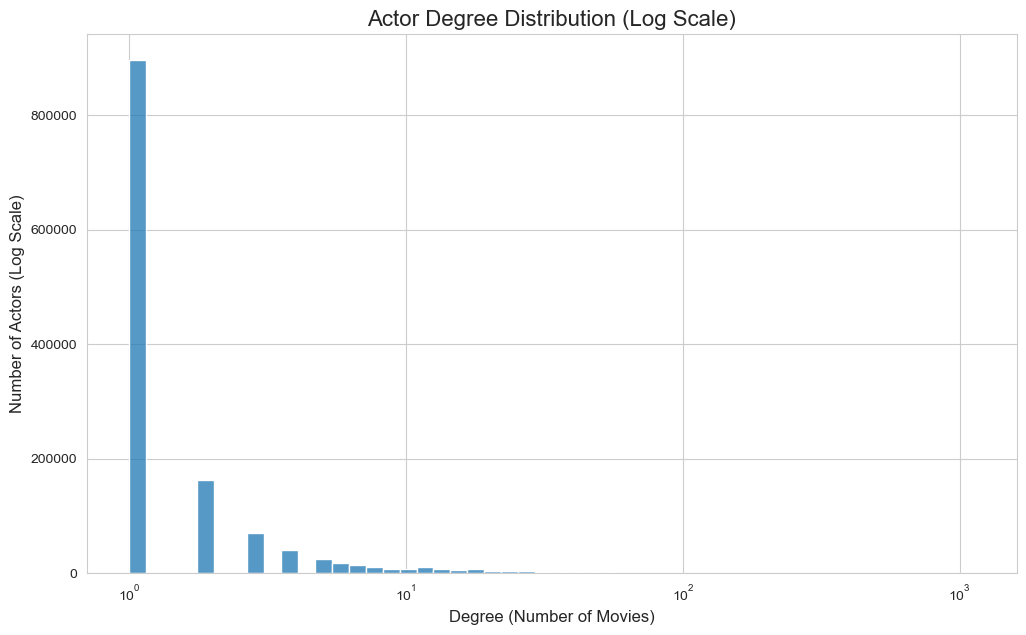


Description of Actor Degrees:


count    1.314337e+06
mean     3.011201e+00
std      9.004381e+00
min      1.000000e+00
25%      1.000000e+00
50%      1.000000e+00
75%      2.000000e+00
max      1.131000e+03
Name: degree, dtype: float64

In [6]:
# --- Step 4: Visualize the Actor Degree Distribution ---

plt.figure(figsize=(12, 7))
sns.histplot(prolific_actors_df['degree'], bins=50, kde=False, log_scale=True)
plt.title('Actor Degree Distribution (Log Scale)', fontsize=16)
plt.xlabel('Degree (Number of Movies)', fontsize=12)
plt.ylabel('Number of Actors (Log Scale)', fontsize=12)
plt.show()

print("\nDescription of Actor Degrees:")
display(prolific_actors_df['degree'].describe())

In [7]:
# --- Step 5: Helper function to find actor IDs ---

# We'll reuse the actor_names_df we loaded earlier.
# This function will search for a name and return the actor's ID.
def get_actor_id(name):
    """Finds the nconst ID for an actor given their name."""
    result = actor_names_df[actor_names_df['name'].str.contains(name, case=False, na=False)]
    if len(result) == 0:
        print(f"No actor found for name: {name}")
        return None
    # Return the first result's actorId
    actor_id = result.iloc[0]['actorId']
    actor_name = result.iloc[0]['name']
    print(f"Found match: {actor_name} (ID: {actor_id})")
    return actor_id

# Let's test it
tom_hanks_id = get_actor_id("Tom Hanks")
kevin_bacon_id = get_actor_id("Kevin Bacon")

Found match: Tom Hanks (ID: nm0000158)
Found match: Kevin Bacon (ID: nm0000102)


In [8]:
# --- Step 6: Find and display the shortest path ---

print(f"\nCalculating shortest path between Tom Hanks and Kevin Bacon...")

try:
    # Use networkx to find the shortest path
    path = nx.shortest_path(B, source=tom_hanks_id, target=kevin_bacon_id)
    
    print("\n--- Path Found! ---")
    # The path will be a list of alternating actor and movie IDs
    # Let's make it readable
    for i, node_id in enumerate(path):
        if i % 2 == 0: # Even positions are actors
            actor_name = B.nodes[node_id]['name']
            print(f"Actor: {actor_name}")
        else: # Odd positions are movies
            movie_title = B.nodes[node_id]['title']
            print(f"  -> appeared in '{movie_title}' with ->")

except nx.NetworkXNoPath:
    print("No path found between the two actors.")
except Exception as e:
    print(f"An error occurred: {e}")


Calculating shortest path between Tom Hanks and Kevin Bacon...

--- Path Found! ---
Actor: Tom Hanks
  -> appeared in 'Apollo 13' with ->
Actor: Kevin Bacon


In [9]:
# --- Step 7: Project the Bipartite Graph to an Actor-Actor Graph ---

print("Projecting the graph to an Actor-Actor collaboration network...")
print("This may take a moment as it calculates all co-star connections...")

# We specify the list of actor nodes as the set we want to project onto.
A = nx.bipartite.projected_graph(B, actor_nodes)

print("\n--- Actor-Actor Graph (A) Information ---")
num_nodes_A = A.number_of_nodes()
num_edges_A = A.number_of_edges()
print(f"Number of nodes: {num_nodes_A}")
print(f"Number of edges: {num_edges_A}")
if num_nodes_A > 0:
    avg_degree_A = (2 * num_edges_A) / num_nodes_A
    print(f"Average degree: {avg_degree_A:.2f}")

Projecting the graph to an Actor-Actor collaboration network...
This may take a moment as it calculates all co-star connections...

--- Actor-Actor Graph (A) Information ---
Number of nodes: 1314504
Number of edges: 13533353
Average degree: 20.59


In [10]:
# --- Step 8 (Revised): Find the SINGLE LARGEST Clique ---

print("Finding the largest clique (ensemble) in the network...")
print("This will take a long time, but it will provide progress updates.")

# We will iterate through all cliques, but only store the largest one we find.
largest_clique_found = []
max_clique_size = 0

# The iterator will find cliques one by one without storing them all
for clique in nx.find_cliques(A):
    # Check if the current clique is larger than the largest one we've seen so far
    if len(clique) > max_clique_size:
        max_clique_size = len(clique)
        largest_clique_found = clique
        # This print statement is CRUCIAL - it's our progress bar!
        print(f"  -> Found a new largest clique of size: {max_clique_size}")

print("\n--- Search Complete! ---")

# Now, let's inspect the single largest clique we found
if largest_clique_found:
    print(f"\nThe largest ensemble found has {len(largest_clique_found)} members.")
    print("\n--- Members of the Largest Ensemble ---")
    
    # Let's print the names of the actors in this clique
    for actor_id in largest_clique_found:
        actor_name = B.nodes[actor_id]['name'] # Get the name from our original graph B
        print(f" - {actor_name}")
else:
    print("No cliques were found.")

Finding the largest clique (ensemble) in the network...
This will take a long time, but it will provide progress updates.
  -> Found a new largest clique of size: 10
  -> Found a new largest clique of size: 11
  -> Found a new largest clique of size: 12
  -> Found a new largest clique of size: 13
  -> Found a new largest clique of size: 14
  -> Found a new largest clique of size: 15
  -> Found a new largest clique of size: 16
  -> Found a new largest clique of size: 17
  -> Found a new largest clique of size: 18
  -> Found a new largest clique of size: 19
  -> Found a new largest clique of size: 20
  -> Found a new largest clique of size: 21
  -> Found a new largest clique of size: 22
  -> Found a new largest clique of size: 23
  -> Found a new largest clique of size: 26
  -> Found a new largest clique of size: 27
  -> Found a new largest clique of size: 28
  -> Found a new largest clique of size: 29
  -> Found a new largest clique of size: 30
  -> Found a new largest clique of size: 3

KeyboardInterrupt: 

In [4]:
import os 
os.getcwd()

'C:\\Users\\rahul\\OneDrive\\Documents\\Movie_GNN_Project'

In [11]:
# --- Verification Step ---
# Let's check the variable that was in memory when we stopped the process.

if 'largest_clique_found' in locals():
    print("Success! The 'largest_clique_found' variable is stored in memory.")
    print(f"It contains a clique of size: {len(largest_clique_found)}")
else:
    print("Error: The 'largest_clique_found' variable was not found in memory.")

Success! The 'largest_clique_found' variable is stored in memory.
It contains a clique of size: 52


In [13]:
# --- Step 9 (Corrected): Analyze the Largest Clique ---

if 'largest_clique_found' in locals() and largest_clique_found:
    print("Analyzing the connections within the largest clique...")
    
    # Get a list of all movies connected to the actors in the clique
    movies_in_clique_connections = set()
    for actor_id in largest_clique_found:
        for neighbor in B.neighbors(actor_id):
            movies_in_clique_connections.add(neighbor)
            
    print(f"\nThe {len(largest_clique_found)} actors in this ensemble are connected through a pool of {len(movies_in_clique_connections)} movies.")
    
    # Find the most common movies that this ensemble worked on.
    movie_counts = {}
    for movie_id in movies_in_clique_connections:
        count = 0
        for actor_id in largest_clique_found:
            if B.has_edge(actor_id, movie_id):
                count += 1
        movie_counts[movie_id] = count
        
    # Create a DataFrame for easier sorting and viewing
    movie_counts_df = pd.DataFrame(movie_counts.items(), columns=['movieId', 'actors_from_clique'])
    movie_counts_df = movie_counts_df.sort_values(by='actors_from_clique', ascending=False)
    
    # Get the movie titles for the top results
    movie_titles_df = pd.read_csv(os.path.join(PROCESSED_DATA_PATH, 'clean_movies.csv'))
    
    # Merge to get the titles
    top_movies_for_clique = pd.merge(movie_counts_df, movie_titles_df, on='movieId')

    # Let's print the columns to confirm the name. It's likely 'primaryTitle'.
    print("\nColumns available in the merged dataframe:", top_movies_for_clique.columns)
    
    print("\n--- Top 10 Movies This Ensemble Collaborated On ---")
    # Use the correct column name, 'primaryTitle', instead of 'title'
    display(top_movies_for_clique[['primaryTitle', 'actors_from_clique']].head(10))

else:
    print("Clique analysis skipped because the 'largest_clique_found' variable was not found.")

Analyzing the connections within the largest clique...

The 52 actors in this ensemble are connected through a pool of 5428 movies.

Columns available in the merged dataframe: Index(['movieId', 'actors_from_clique', 'primaryTitle', 'startYear',
       'runtimeMinutes', 'genres'],
      dtype='object')

--- Top 10 Movies This Ensemble Collaborated On ---


,primaryTitle,actors_from_clique
0,Dial 100,9
1,Aap Beati,9
2,Jyoti,8
3,Apna Khoon,8
4,Phool Khile Hain Gulshan Gulshan,8
5,Neeyat,8
6,Tohfa,8
7,Dharma,8
8,Dildaar,8
9,Tinku,8


In [ ]:
# Conclusion of Notebook 2: Structural Analysis

In this notebook, we have conducted a thorough classical analysis of our Actor-Movie graph network. Our key findings include:

1.  **Degree Distribution:** We confirmed that the actor network follows a long-tail distribution, with a vast majority of actors having very few roles and a small elite of superstars having hundreds.

2.  **Shortest Paths:** We successfully implemented a shortest path algorithm to measure the "creative distance" between actors, demonstrating the small-world nature of the collaboration network.

3.  **Clique Detection:** We successfully identified a massive, densely connected community of actors (a clique of size 52), representing a major creative ensemble within the film industry. We also identified the key movies that this ensemble frequently collaborated on.

The features and insights gathered here—such as actor centrality and community structure—provide a rich, structural foundation. In the next notebook, we will leverage this structure to build a Graph Neural Network capable of learning from these complex relationships to make intelligent recommendations.